In [1]:
import click as ck
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import function
import re
import math
import matplotlib.pyplot as plt
import logging
from tensorflow.keras.layers import (
    Input,
)
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras import backend as K
from scipy.stats import rankdata

from elembeddings.elembedding import (
    ELModel, load_data, load_valid_data, Generator, MyModelCheckpoint)



/home/leechuck/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/leechuck/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/leechuck/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

### Set parameters

In [2]:
# Parameters
batch_size = 32
embedding_size = 50
margin = -0.01
reg_norm = 1
learning_rate = 3e-4
epochs = 128

### Load training and validation data

In [3]:
train_data, classes, relations = load_data('data/data-train/yeast-classes-normalized.owl')
valid_data = load_valid_data('data/data-valid/4932.protein.links.v10.5.txt', classes, relations)
    
proteins = {}
for k, v in classes.items():
    if not k.startswith('<http://purl.obolibrary.org/obo/GO_'):
        proteins[k] = v

nb_classes = len(classes)
nb_relations = len(relations)
nb_train_data = 0
for key, val in train_data.items():
    nb_train_data = max(len(val), nb_train_data)
train_steps = int(math.ceil(nb_train_data / (1.0 * batch_size)))
train_generator = Generator(train_data, batch_size, steps=train_steps)

cls_dict = {v: k for k, v in classes.items()}
rel_dict = {v: k for k, v in relations.items()}

cls_list = []
rel_list = []
for i in range(nb_classes):
    cls_list.append(cls_dict[i])
for i in range(nb_relations):
    rel_list.append(rel_dict[i])

        
print(nb_classes, nb_relations)

51671 10


### Build ELEmbeddings Model and Train

Embeddings are saved depending on mean rank evaluation on validation set

In [5]:
nf1 = Input(shape=(2,), dtype=np.int32)
nf2 = Input(shape=(3,), dtype=np.int32)
nf3 = Input(shape=(3,), dtype=np.int32)
nf4 = Input(shape=(3,), dtype=np.int32)
dis = Input(shape=(3,), dtype=np.int32)
top = Input(shape=(1,), dtype=np.int32)
nf3_neg = Input(shape=(3,), dtype=np.int32)
el_model = ELModel(nb_classes, nb_relations, embedding_size, batch_size, margin, reg_norm)
out = el_model([nf1, nf2, nf3, nf4, dis, top, nf3_neg])
model = tf.keras.Model(inputs=[nf1, nf2, nf3, nf4, dis, top, nf3_neg], outputs=out)
optimizer = optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

out_classes_file = 'data/cls_embeddings.pkl'
out_relations_file = 'data/rel_embeddings.pkl'

checkpointer = MyModelCheckpoint(
    out_classes_file=out_classes_file,
    out_relations_file=out_relations_file,
    cls_list=cls_list,
    rel_list=rel_list,
    valid_data=valid_data,
    proteins=proteins,
    monitor='loss')
        
model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    workers=12,
    callbacks=[checkpointer,])


AttributeError: 'Generator' object has no attribute 'shape'

### Evaluation of embeddings on the test set

In [7]:
def load_test_data(data_file, classes, relations):
    data = []
    rel = f'<http://interacts>'
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'<http://{it[0]}>'
            id2 = f'<http://{it[1]}>'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((id1, rel, id2))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc

cls_df = pd.read_pickle(out_classes_file)
rel_df = pd.read_pickle(out_relations_file)
nb_classes = len(cls_df)
nb_relations = len(rel_df)
embeds_list = cls_df['embeddings'].values
rembeds_list = rel_df['embeddings'].values
size = len(embeds_list[0])
embeds = np.zeros((nb_classes, size), dtype=np.float32)
for i, emb in enumerate(embeds_list):
    embeds[i, :] = emb

rs = np.abs(embeds[:, -1]).reshape(-1, 1)
embeds = embeds[:, :-1]
prot_index = list(proteins.values())
prot_rs = rs[prot_index, :]
prot_embeds = embeds[prot_index, :]
prot_dict = {v: k for k, v in enumerate(prot_index)}
    
rsize = len(rembeds_list[0])
rembeds = np.zeros((nb_relations, rsize), dtype=np.float32)
for i, emb in enumerate(rembeds_list):
    rembeds[i, :] = emb

train_data = load_test_data('data/data-train/4932.protein.links.v10.5.txt', classes, relations)
valid_data = load_test_data('data/data-valid/4932.protein.links.v10.5.txt', classes, relations)
trlabels = {}
for c, r, d in train_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000
for c, r, d in valid_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000

test_data = load_test_data('data/data-test/4932.protein.links.v10.5.txt', classes, relations)
top1 = 0
top10 = 0
top100 = 0
mean_rank = 0
ftop1 = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
labels = {}
preds = {}
ranks = {}
franks = {}
eval_data = test_data
n = len(eval_data)
for c, r, d in eval_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in labels:
        labels[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    if r not in preds:
        preds[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.float32)
    labels[r][c, d] = 1
    ec = prot_embeds[c, :]
    rc = prot_rs[c, :]
    er = rembeds[r, :]
    ec += er

    # Compute similarity
    dst = np.linalg.norm(prot_embeds - ec.reshape(1, -1), axis=1)
    dst = dst.reshape(-1, 1)
    res = np.maximum(0, dst - rc - prot_rs - margin)
    res = res.flatten()

    preds[r][c, :] = res
    index = rankdata(res, method='average')
    rank = index[d]
    if rank == 1:
        top1 += 1
    if rank <= 10:
        top10 += 1
    if rank <= 100:
        top100 += 1
    mean_rank += rank
    if rank not in ranks:
        ranks[rank] = 0
    ranks[rank] += 1

    # Filtered rank
    index = rankdata((res * trlabels[r][c, :]), method='average')
    rank = index[d]
    if rank == 1:
        ftop1 += 1
    if rank <= 10:
        ftop10 += 1
    if rank <= 100:
        ftop100 += 1
    fmean_rank += rank

    if rank not in franks:
        franks[rank] = 0
    franks[rank] += 1
top1 /= n
top10 /= n
top100 /= n
mean_rank /= n
ftop1 /= n
ftop10 /= n
ftop100 /= n
fmean_rank /= n

rank_auc = compute_rank_roc(ranks, len(proteins))
frank_auc = compute_rank_roc(franks, len(proteins))

print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')

0.09 0.50 268.42 0.95
0.23 0.74 210.26 0.96


### TSNE

In [6]:
from matplotlib import pyplot as plt
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

X = TSNE(n_components=2, verbose=1, n_iters=2500, n_jobs=8).fit_transform(prot_embeds)



TypeError: __init__() got an unexpected keyword argument 'n_iters'

### Example plot


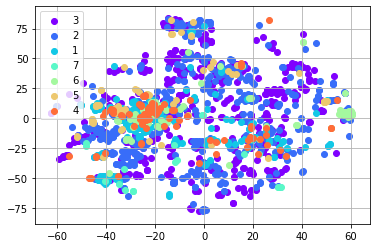

In [9]:
from matplotlib.pyplot import cm

# Load EC numbers
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '<http://{0}>'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

classes = {'0': [[], []]}
for i, item in enumerate(proteins.items()):
    k, v = item
    if k in ec_numbers:
        ec = ec_numbers[k].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[i, 0])
        classes[ec][1].append(X[i, 1])
    else:
        classes['0'][0].append(X[i, 0])
        classes['0'][1].append(X[i, 1])
    
colors = iter(cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots()

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()
